<a href="https://www.kaggle.com/code/chakreshkrsingh/multiclass-classification-using-svm-pca-tsne?scriptVersionId=159434282" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Data Set information - 

Digit database was created by collecting 250 samples from 44 writers. These writers are asked to write 250 digits from **0-9** in random order inside boxes of 500 by 500 tablet pixel resolution. The digit dataset then is so transformed that each digit is a unique vector of 16 dimensions. 

        Number of Samples = 10992
        Number of Features = 16

This data set can be used to test both supervised classification and unsupervised clustering. 

For more information follow the open repository [here](https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits) and the corresponding [paper](https://ieeexplore.ieee.org/document/620583)

#### Goal of the analysis - We want to showcase the use of dimensionality reductions to visualize high dimensional data in a more interpretable and visually appealing way. Such methods make the interpretation of complex data easy and help in communicating with the stakeholders. 


### Roadmap 

We split the analysis of the pen digit data-set into 3 sections - 

* [Supervised Classification](#svm_classifier)

We test the Support Vector Machine Classifier to test the performance of the classifier on a well defined data to quickly revise supervised classification and also setup a base for testing the classes in unsupervised learning

* [KMeans Clustering](#kmeans-clustering)

Here we use the kmeans clustering algorithm to cluster our data after removing the labels. We aim to see how the clustering performs with increasing number of 'n_clusters' parameter. The goal will be to check if the method reveals the ideal number of clusters to be used, which we know is = 10

* [Dimensionality Reduction](#dim-red)

    * [PCA](#pca-red) - Next we perform Principal Component Analysis and check the explained variance with the number of components. We then use PCA to reduce the datas to two dimensions and visualize the clusters and show the significance of dimensionality reduction. 
    
    * [TSNE](#tsne-red) - We extend the dimensionality reduction analysis to TSNE algorithm to produce better clustered data
    
    



In [2]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.manifold import TSNE

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 

In [3]:
## Loading the data 

Pen_DF = pd.read_csv('/kaggle/input/pendigits/dataset_32_pendigits.csv',header=0,sep=',',index_col=0)

In [4]:
Pen_DF.head()

,'input1','input2','input3','input4','input5','input6','input7','input8','input9','input10','input11','input12','input13','input14','input15','input16','class'
id,,,,,,,,,,,,,,,,,
1,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
2,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
3,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
4,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
5,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


In [5]:
feat_cols = Pen_DF.columns[:-1] ## removing the last column since it is the labels 
print(feat_cols)

Index([''input1'', ''input2'', ''input3'', ''input4'', ''input5'', ''input6'',
       ''input7'', ''input8'', ''input9'', ''input10'', ''input11'',
       ''input12'', ''input13'', ''input14'', ''input15'', ''input16''],
      dtype='object')


In [6]:
labels = list(set(Pen_DF["'class'"]))
print(labels)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


### Supervised Classification <a name='svm_classifier'></a>

In [7]:
X_train,x_test,Y_train,y_test = train_test_split(Pen_DF[feat_cols],Pen_DF["'class'"],\
                                                 train_size=0.85,stratify=Pen_DF["'class'"])

In [8]:
svm = SVC(max_iter=1000,tol=1e-5)

svm.fit(X_train,Y_train)

SVC(max_iter=1000, tol=1e-05)

In [9]:
predictions = svm.predict(x_test)

In [10]:
### for multiclass cases change the 'average' and provide labels
f1 = f1_score(y_test,predictions,labels=labels,average='micro') 

acc = accuracy_score(y_test,predictions)
cf = confusion_matrix(y_test,predictions)

Text(0.5, 1.0, 'Confusion Matrix for the SVC Classifier')

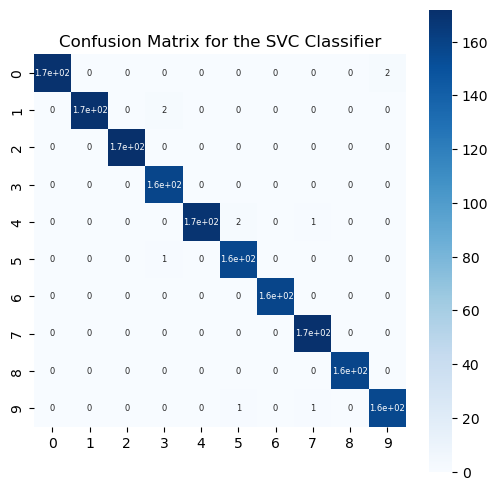

In [11]:
### Draw the Confusion Matrix 

plt.figure(figsize=(6,6))
sns.heatmap(cf,xticklabels=labels,yticklabels=labels,annot=True,cmap='Blues',square=True,annot_kws={"size":6})
plt.title('Confusion Matrix for the SVC Classifier')

In [12]:
print('Using Support Vector Machine for Classification we get \n \n','f1 score : ',\
      round(f1,3), ' \n Accuracry : ', round(acc,3))

Using Support Vector Machine for Classification we get 
 
 f1 score :  0.994  
 Accuracry :  0.994


### KMeans Clustering <a name='kmeans-clustering'></a>

In [13]:
X = Pen_DF[feat_cols] ## Removing the labels from the data

In [14]:
### Running the KMeans clustering for different number of clusters and recording the inertia. 

nc = range(5,30)
inert = []

for n in nc:
    km = KMeans(n_clusters=n,n_init=10)
    km.fit(X)
    
    inert.append(km.inertia_)

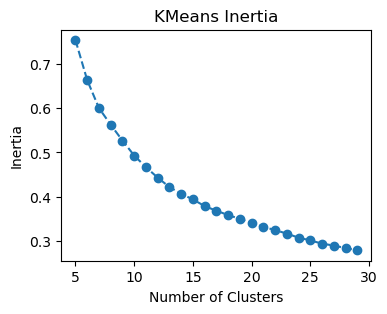

In [15]:
plt.figure(figsize=(4,3))
plt.plot(nc,np.array(inert)/1e8,'--o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('KMeans Inertia')
plt.show()

### here we expect the inertia to plateau around 10. However, this is not the case. The inertia keeps decreasing with increasing number of clusters. This suggests that KMeans is not well suited in this case. Therefore to clearly separate and visualize our clusters we use dimensionality reduction. 

## Dimensionality Reduction <a name = 'dim-red' ></a>

### Principal Component Analysis <a name = 'pca-red' ></a>

In [16]:
pca = PCA(n_components=15,random_state=42)

pca.fit(X)

PCA(n_components=15, random_state=42)

Text(0, 0.5, 'Explained Variance')

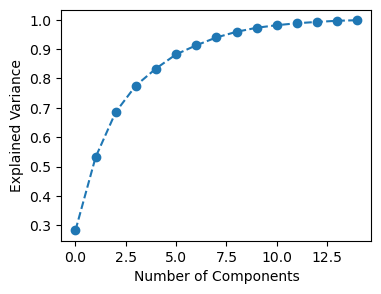

In [17]:
plt.figure(figsize=(4,3))
plt.plot(range(15),np.cumsum(pca.explained_variance_ratio_),'--o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

Note here that in PCA we cannot have number of components more than the number of features. 

In [18]:
## Now we will use PCA for dimensionality reduction to visualize the clusters better
pca = PCA(n_components=2)
X_t = pca.fit_transform(X)

Text(0.5, 1.0, 'Pen Digits Data using PCA (Uncolored)')

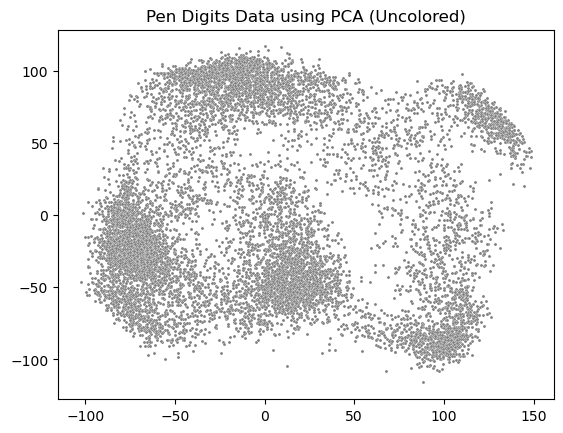

In [19]:
sns.scatterplot(data=Pen_DF,x=X_t[:,0],y=X_t[:,1],s=5,color='gray')
plt.title('Pen Digits Data using PCA (Uncolored)')

### without any labels, using PCA we can see some clusters. Now we color them according to their labels

Text(0.5, 1.0, 'Pen Digits Data using PCA (colored)')

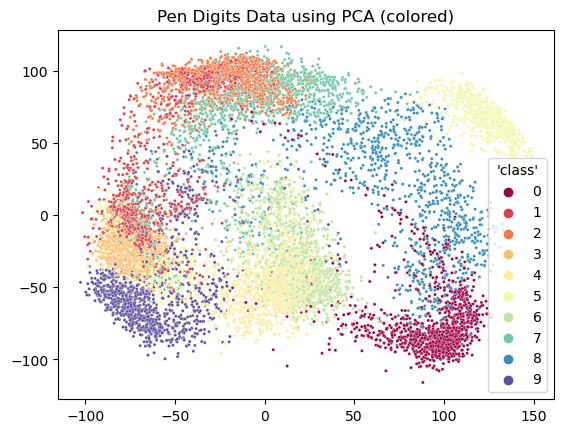

In [20]:
sns.scatterplot(data=Pen_DF,x=X_t[:,0],y=X_t[:,1],hue="'class'",s=5,palette='Spectral',legend="full")
plt.title('Pen Digits Data using PCA (colored)')

The clusters are clearer. The overlap is between similar looking digits such as 5 and 6, 1 and 7 etc.

#### We will improve the distinction between clusters by using TSNE

In [21]:
tsne = TSNE(n_components=2,learning_rate=50,perplexity=10,random_state=42)

In [ ]:
X_tsne = tsne.fit_transform(X)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [ ]:
sns.scatterplot(data=Pen_DF,x=X_tsne[:,0],y=X_tsne[:,1],s=5,color='gray')
plt.title('Pen Digits Data using TSNE (un-colored)')

Already we see clusters more clearly. Now Coloring them based on their classes

In [ ]:
sns.scatterplot(data=Pen_DF,x=X_tsne[:,0],y=X_tsne[:,1],hue="'class'",s=5,palette='colorblind',legend="full")
plt.title('Pen Digits Data using TSNE')

## Conclusion

### Key Insights - 

* Dimensionality Reduction help visualize complex data in higher dimensions in more interpretable appealing format in lower dimensions. 